In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

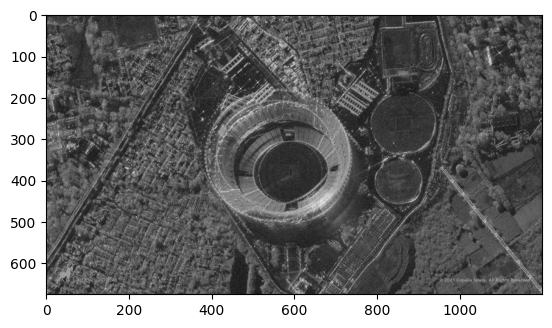

In [3]:
plt.imshow(image_gray, cmap="gray")

# Алгоритм разрастания регионов

In [4]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False
    

In [5]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask
        
    return mask*255
    

In [6]:
seed_point = (250,250)
mask = region_growing(image_gray,seed_point,homo_average,1, 10)

0


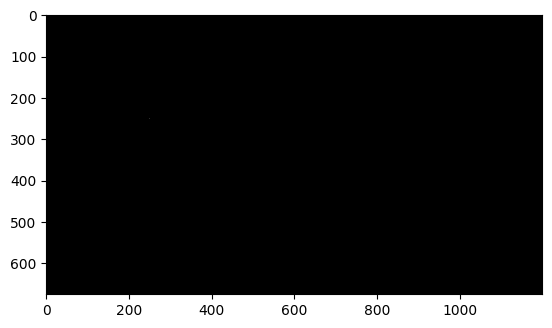

In [7]:
plt.imshow(mask, cmap="gray")

# K-means

In [8]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [9]:
flags = cv2.KMEANS_RANDOM_CENTERS

In [10]:
z = image_gray.reshape((-1,3))
# convert to np.float32
z = np.float32(z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

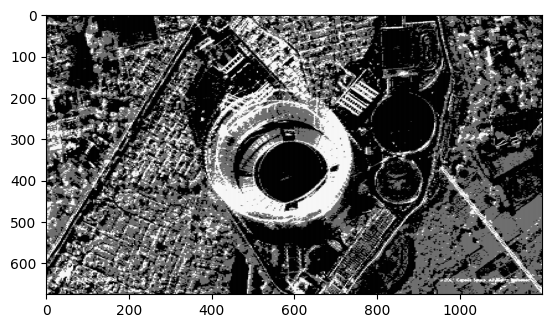

In [11]:
plt.imshow(res2, cmap="gray")

# Watershed+Distance transform

In [12]:
image = cv2.imread('oranges_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

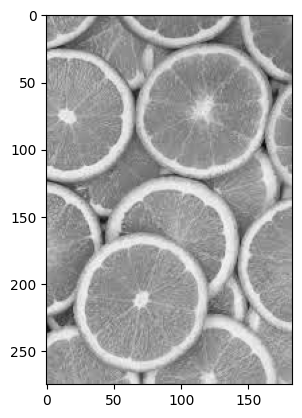

In [13]:
plt.imshow(image_gray, cmap="gray")

In [14]:
ret, thresh = cv2.threshold(image_gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

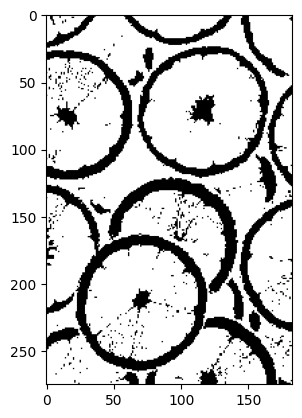

In [15]:
plt.imshow(thresh, cmap="gray")

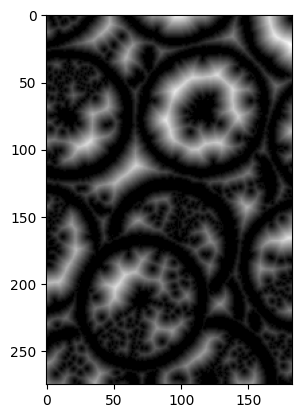

In [16]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
plt.imshow(dist, cmap="gray")

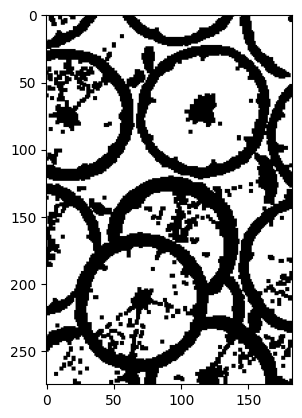

In [17]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY) 
plt.imshow(sure_fg, cmap="gray")

In [18]:
sure_fg = sure_fg.astype(np.uint8)

In [19]:
ret, markers = cv2.connectedComponents(sure_fg) 

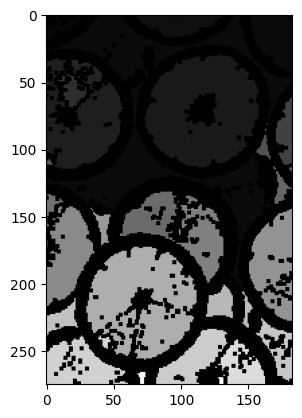

In [20]:
plt.imshow(markers, cmap="gray")

In [21]:
markers = cv2.watershed(image, markers)

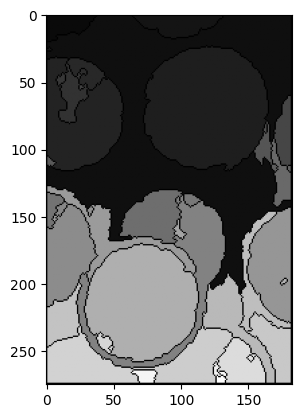

In [22]:
plt.imshow(markers, cmap="gray")

In [23]:
# ДЗ 4
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [24]:
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.


In [25]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

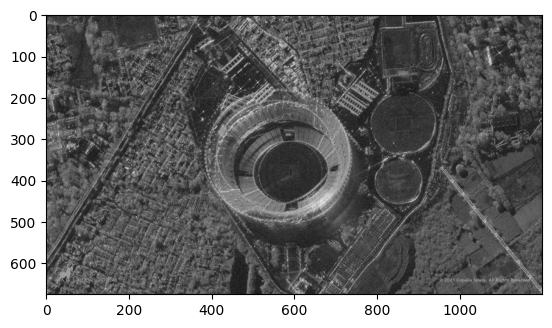

In [26]:
plt.imshow(image_gray, cmap="gray")

In [27]:
import math
def homo_average(img, mask, point, T):
    av_val = np.median(img[mask > 0]) 
    if abs(av_val - img[point]) <= T:
        return True                    # если среднее (медианное) значение по области действия маски сравнимо со значением в точке
    return False

In [28]:
from collections import deque

In [29]:
def region_growing_fast(image, seed_point, r, T):
    mask = np.zeros(image.shape, dtype=np.uint8)
    mask[seed_point] = 1
    queue = deque([seed_point])
    while queue:
        i, j = queue.popleft()
        neighbors = [
            (i-1, j-1), (i-1, j), (i-1, j+1),
            (i, j-1),             (i, j+1),
            (i+1, j-1), (i+1, j), (i+1, j+1)
        ]
        for ni, nj in neighbors:
            if 0 <= ni < image.shape[0] and 0 <= nj < image.shape[1]:
                if mask[ni, nj] == 0:
                    i_min, i_max = max(0, ni-r), min(image.shape[0], ni+r+1)
                    j_min, j_max = max(0, nj-r), min(image.shape[1], nj+r+1)
                    local_mask = mask[i_min:i_max, j_min:j_max]
                    local_img = image[i_min:i_max, j_min:j_max]      
                    if local_mask.sum() > 0:
                        av_val = np.median(local_img[local_mask > 0])              
                        if abs(av_val - image[ni, nj]) <= T:
                            mask[ni, nj] = 1
                            queue.append((ni, nj))
    
    return mask * 255

In [30]:
mask = region_growing_fast(image_gray, (250, 300), r=5, T=20)

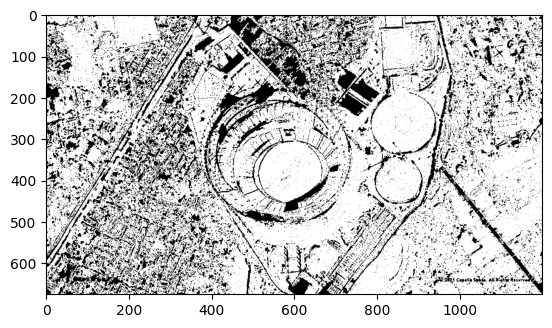

In [31]:
plt.imshow(mask, cmap="gray")

In [32]:
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

In [33]:
z = np.float32(image_gray.reshape((-1,3)))

# количество кластеров (яркостей)
K1 = 2
K2 = 3
K3 = 10

# количество итераций 5, точность 0.1
criteria1 = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 0.1) 

# количество итераций 5, точность 1
criteria2 = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 5, 1.0) 

# количество итераций 90, точность 0.1
criteria3 = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 90, 0.1)

ret1, label1, center1 = cv2.kmeans(z, K1, None, criteria1, 10, cv2.KMEANS_RANDOM_CENTERS)
ret2, label2, center2 = cv2.kmeans(z, K2, None, criteria2, 10, cv2.KMEANS_RANDOM_CENTERS)
ret3, label3, center3 = cv2.kmeans(z, K3, None, criteria3, 50, cv2.KMEANS_RANDOM_CENTERS)

# восстановление изображения
center1 = np.uint8(center1)
res = center1[label1.flatten()]
res1 = res.reshape((image_gray.shape))

center2 = np.uint8(center2)
res = center2[label2.flatten()]
res2 = res.reshape((image_gray.shape))

center3 = np.uint8(center3)
res = center3[label3.flatten()]
res3 = res.reshape((image_gray.shape))

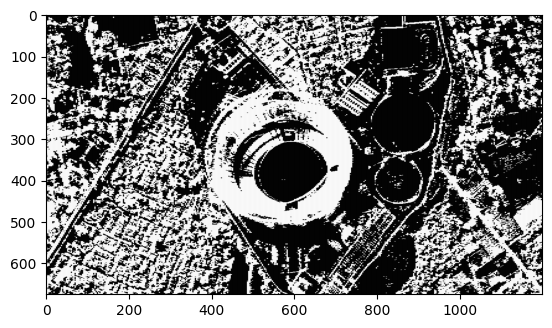

In [34]:
plt.imshow(res1, cmap="gray")

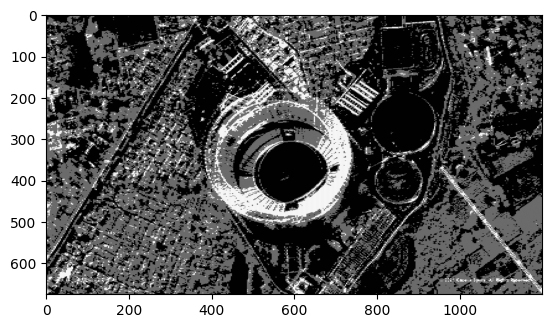

In [35]:
plt.imshow(res2, cmap="gray")

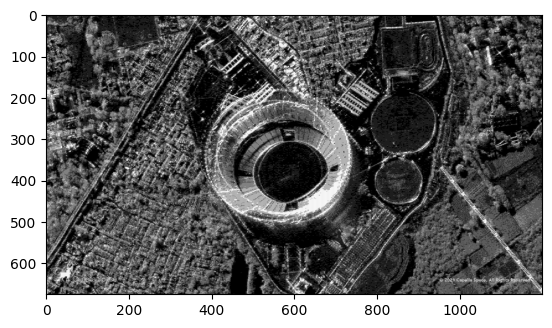

In [36]:
plt.imshow(res3, cmap="gray")

In [37]:
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [39]:
palm = cv2.imread("palm_1.JPG")
palm_gray = cv2.cvtColor(palm, cv2.COLOR_BGR2GRAY)

In [40]:
blurred = cv2.GaussianBlur(palm_gray, (13, 13), 0)

ret1, thresh_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ret2, thresh_fixed = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)
thresh_adaptive = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

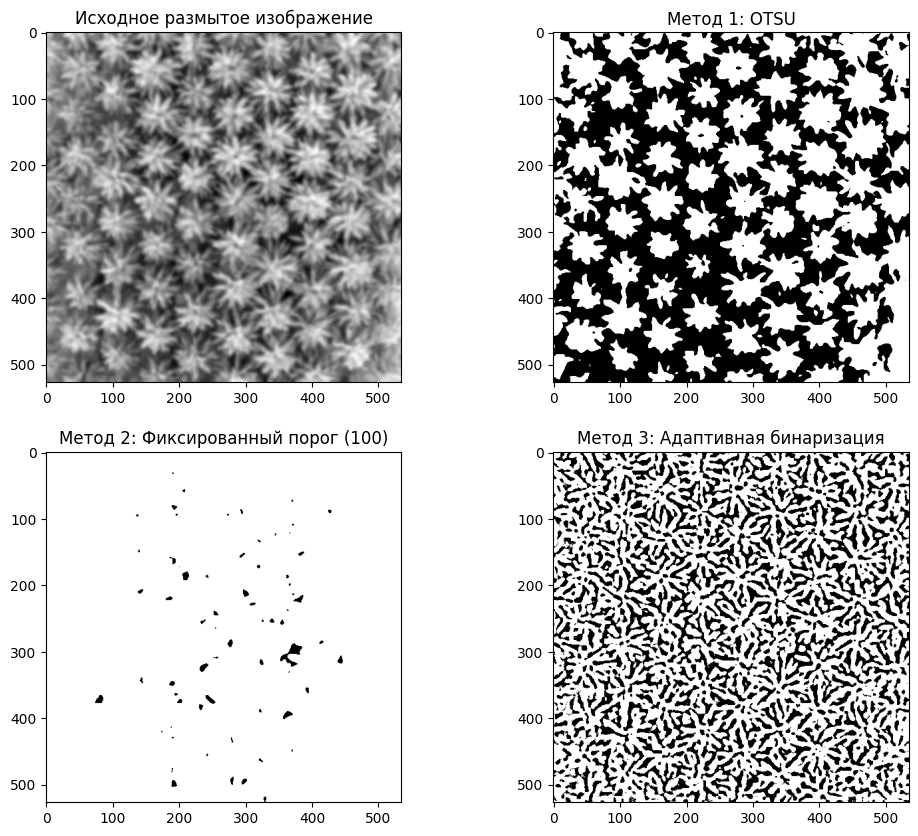

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].imshow(blurred, cmap="gray")
axes[0, 0].set_title("Исходное размытое изображение")
axes[0, 1].imshow(thresh_otsu, cmap="gray")
axes[0, 1].set_title("Метод 1: OTSU")
axes[1, 0].imshow(thresh_fixed, cmap="gray")
axes[1, 0].set_title("Метод 2: Фиксированный порог (100)")
axes[1, 1].imshow(thresh_adaptive, cmap="gray")
axes[1, 1].set_title("Метод 3: Адаптивная бинаризация")
plt.show()

In [42]:
thresh = thresh_otsu

In [43]:
kernel = np.ones((3, 3), np.uint8)
thresh = cv2.dilate(thresh, kernel, iterations=2)
thresh = cv2.erode(thresh, kernel, iterations=2)

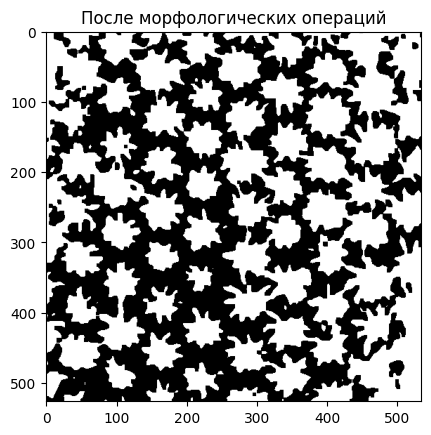

In [44]:
plt.imshow(thresh, cmap="gray")
plt.title("После морфологических операций")
plt.show()

In [45]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

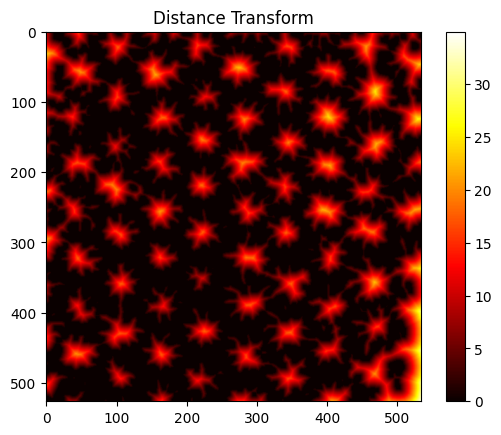

In [46]:
plt.imshow(dist, cmap="hot")
plt.title("Distance Transform")
plt.colorbar()
plt.show()

In [47]:
ret, sure_fg = cv2.threshold(dist, 0.12 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = np.uint8(sure_fg)

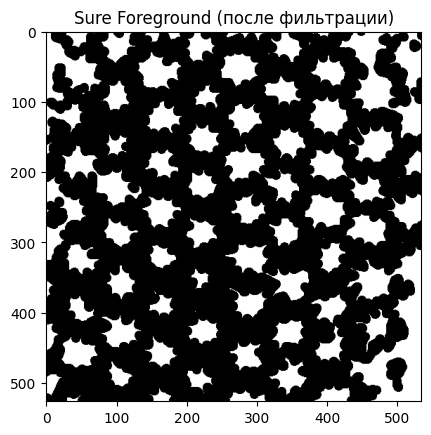

In [48]:
plt.imshow(sure_fg, cmap="gray")
plt.title("Sure Foreground (после фильтрации)")
plt.show()

In [49]:
ret, labels_fg = cv2.connectedComponents(sure_fg)

In [50]:
if ret > 1:
    component_sizes = np.bincount(labels_fg.flatten())
    largest_component = np.argmax(component_sizes[1:]) + 1
    largest_mask = (labels_fg == largest_component).astype(np.uint8) * 255

    M = cv2.moments(largest_mask)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        seed_point = (cy, cx)
    else:
        seed_point = (palm_gray.shape[0] // 2, palm_gray.shape[1] // 2)
else:
    seed_point = (palm_gray.shape[0] // 2, palm_gray.shape[1] // 2)

In [51]:
mark = labels_fg.copy().astype(np.int32)
mark = cv2.watershed(palm, mark)

In [52]:
count = ret - 2

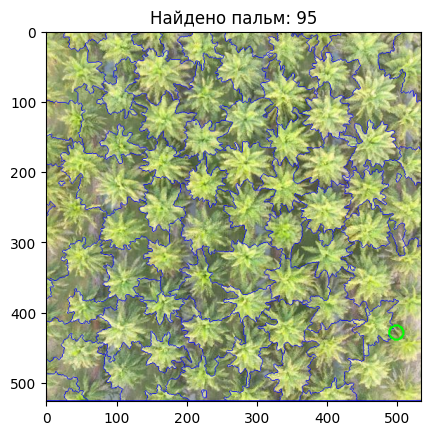

In [53]:
palm_res = palm.copy()
palm_res[mark == -1] = [255, 0, 0]
cv2.circle(palm_res, (seed_point[1], seed_point[0]), 10, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(palm_res, cv2.COLOR_BGR2RGB))
plt.title(f"Найдено пальм: {count}")
plt.show()

In [54]:
print(f"Кол-во пальм: {count}")

Кол-во пальм: 95
